In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl

In [3]:
wine_df = pd.read_csv('data/wine.csv')
#dropping catagorical features, quality and type
wine_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,2
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,2
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,2
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [4]:
df = pd.concat([wine_df,pd.get_dummies(wine_df.quality,prefix='quality'),pd.get_dummies(wine_df.wine_type,prefix='wine_type')],axis=1)

In [5]:
df = df.drop(['quality','wine_type'],axis=1)

In [6]:
wine_df.wine_type.value_counts()

2    4898
1    1599
Name: wine_type, dtype: int64

In [7]:
wine_df.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [7]:
dfshape = df.shape

In [8]:
df.iloc[0,4]

0.045

Need to figure out some random locs to sub sample, we can do this based on a percentage of rows/colums or total points

In [8]:
def random_loc(data_frame_shape):
    col = np.random.randint(0,data_frame_shape[1])
    row = np.random.randint(0,data_frame_shape[0])
    return row,col

In [14]:
random_loc(dfshape)

(1283, 3)

In [15]:
random_loc(dfshape)[0]

2001

In [16]:
df.iloc[random_loc(dfshape)[0],random_loc(dfshape)[1]]

0

In [9]:
def induce_missingness(dataframe,percent):
    np.random.seed(999)
    num2nan = int(dataframe.shape[0]*dataframe.shape[1]*percent)
    
    dfout = dataframe.copy()
    
    for _ in range(num2nan): 
        
        randloc = random_loc(dataframe.shape)
        
        while dfout.iloc[randloc[0],randloc[1]] == np.nan:
            randloc = random_loc(dataframe.shape)
            
        dfout.iloc[randloc[0],randloc[1]] = np.nan
        
        
    
    return dfout 
    

In [10]:
dout = induce_missingness(df,0.01)

In [11]:
df.shape

(6497, 20)

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()
scaler.fit(df.to_numpy())
df_scaled = pd.DataFrame(data=scaler.transform(df.to_numpy()),columns=df.columns)

In [14]:
col_type = pd.DataFrame(data=np.array([np.nan]*20).reshape(1,20),columns=df_scaled.columns)
for col in df_scaled.columns:
    #print(col,len(df_scaled[col].unique()))
    
    if len(df_scaled[col].unique()) < 3:
        col_type[col] = 'cat'
    else:
        col_type[col] = 'num'
col_type.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,num,num,num,num,num,num,num,num,num,num,num,cat,cat,cat,cat,cat,cat,cat,cat,cat


In [15]:
from Models.simple_VAE import VAE
import argparse
import torch
import torch.utils.data 
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [16]:
def RMSE(darray,recon):
    return np.sqrt(np.mean(np.square(darray - recon)))

In [17]:
def train_model(data_array,model_in,
                optimizer_in,device_in,epochs=50,batch_size=125,mask_in=None):
    
    
    data_iter = DataLoader(dtensor,batch_size=batch_size, shuffle=False)
    mask_iter = DataLoader(torch.FloatTensor(mask_in),batch_size=batch_size, shuffle=False)
    model_in.train()
    
    
    

    loss_store = []

    for epoch in range(epochs): 
        for idx, (batch,mask) in enumerate(zip(data_iter,mask_iter)):
        
        
            batch_in = batch.float()
            optimizer_in.zero_grad()
        
            drecon,mu,log_var =  model_in.forward(batch_in)
            
            loss = model_in.loss((1-mask)*drecon, (1-mask)*batch_in)
            loss.backward()
            optimizer_in.step()


        loss_store.append(loss.item())

    
    plt.plot(loss_store)
    plt.show()

    model_in.eval()
    drecon,mu,log_var =  model(dtensor)
    recon_array = drecon.detach().numpy()
    input_array = dtensor.detach().numpy()#dtensor.detach().numpy()

    return RMSE(input_array,recon_array),model_in

In [149]:
test_recon,mu_test,log_var = model(torch.FloatTensor(test))
z = model.reparam(mu_test,log_var).detach().numpy()

NameError: name 'test' is not defined

In [309]:

z_embedded = TSNE(n_components=2).fit_transform(z)
#>>> X_embedded.shape
#print(z_embedded)

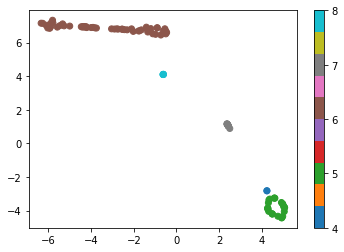

In [335]:
colours = wine_df['quality'].iloc[:100].to_numpy()
bounds = list(set(wine_df['quality'].iloc[:100].to_numpy()))
sc = plt.scatter(z_embedded[:,0],z_embedded[:,1],c=colours, cmap='tab10')
plt.colorbar(sc, ticks=bounds)
plt.show()

In [18]:
def plot_latent_space(data_in,model_in,labels):
    """"""
    test_recon3,mu_out,log_out = model_in(torch.FloatTensor(data_in))
    zout = model_in.reparam(mu_out,log_out).detach().numpy()
    
    z_emb  = TSNE(n_components=2).fit_transform(zout)
    
    colours = labels.to_numpy()
    bounds = list(set(labels.to_numpy()))
    sc = plt.scatter(z_emb[:,0],z_emb[:,1],c=colours, cmap='tab10')
    plt.colorbar(sc, ticks=bounds)
    plt.show()

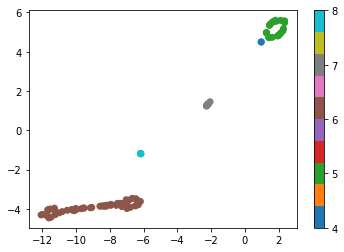

In [343]:
plot_latent_space(test,model,wine_df['quality'].iloc[:100])

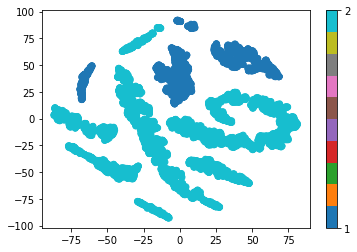

In [346]:
plot_latent_space(darray[100:,:],model,wine_df['wine_type'].iloc[100:]) 

In [18]:
df_shuffle = df_scaled.sample(frac=1,random_state=10)
df_test    = df_shuffle.iloc[:,:].reset_index(drop=True)
df_train   = df_shuffle.iloc[:-1200,:].reset_index(drop=True)
#roughly 20% train test split

In [19]:
df_test.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.214876,0.373333,0.125980,0.018405,0.119601,0.045139,0.057604,0.188476,0.674419,0.247191,0.260870,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.231405,0.226667,0.077758,0.187117,0.058140,0.086806,0.350230,0.204471,0.403101,0.140449,0.144928,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.148760,0.280000,0.053647,0.026074,0.066445,0.055556,0.214286,0.126999,0.705426,0.230337,0.724638,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.925620,0.086667,0.264617,0.024540,0.109635,0.031250,0.041475,0.250337,0.271318,0.348315,0.173913,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.231405,0.073333,0.596142,0.009202,0.187708,0.152778,0.283410,0.125072,0.286822,0.050562,0.101449,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [20]:
torch.manual_seed(999)

In [21]:
df_test_with_nans = induce_missingness(df_test,0.2)

In [22]:
df_test_with_nans.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.214876,0.373333,0.125980,0.018405,0.119601,0.045139,0.057604,0.188476,NaN,0.247191,0.260870,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0
1,0.231405,0.226667,0.077758,0.187117,0.058140,0.086806,0.350230,0.204471,0.403101,0.140449,0.144928,NaN,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0
2,0.148760,0.280000,0.053647,0.026074,0.066445,0.055556,0.214286,0.126999,NaN,0.230337,NaN,0.0,0.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0
3,0.925620,0.086667,0.264617,0.024540,0.109635,0.031250,0.041475,0.250337,0.271318,0.348315,NaN,0.0,NaN,NaN,0.0,1.0,NaN,0.0,1.0,0.0
4,0.231405,0.073333,0.596142,NaN,0.187708,0.152778,NaN,0.125072,0.286822,0.050562,0.101449,0.0,0.0,NaN,1.0,0.0,0.0,NaN,NaN,1.0


In [23]:
from sklearn.impute import MissingIndicator
indicator = MissingIndicator()
indicator.fit(df_test_with_nans)

MissingIndicator()

In [24]:
nan_mask = indicator.transform(df_test_with_nans)

In [25]:
nan_mask_df = pd.DataFrame(data=nan_mask,columns=df_test.columns)
nan_mask_df.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,True,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,True,False,False,False
4,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False


In [26]:
M = len(df_test_with_nans.index)
N = len(df_test_with_nans.columns)
ran = pd.DataFrame(np.random.uniform(size=(M,N)), columns=df_test_with_nans.columns, index=df_test_with_nans.index)

In [27]:
df_test_nans_filled = df_test_with_nans.copy()
df_test_nans_filled[df_test_with_nans.isnull()==True] = ran
(df_test_nans_filled*nan_mask_df).head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.929384,0.0,0.000000,0.000000,0.071553,0.486807,0.000000,0.000000,0.036427,0.000000,0.791168,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.480981,0.000000,0.000000,0.576691,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.319154,0.0,0.923176,0.000000,0.000000,0.000000,0.923970,0.111329,0.000000,0.000000,0.179273,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.726880,0.000000,0.103251,0.855095,0.000000,0.000000,0.389293,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.189089,0.0,0.0,0.743204,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.457487,0.000000,0.000000,0.000000,0.067561,0.854043,0.0


VAE(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (fc11): Linear(in_features=20, out_features=10, bias=True)
  (fc12): Linear(in_features=10, out_features=5, bias=True)
  (fc21): Linear(in_features=5, out_features=10, bias=True)
  (fc22): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc31): Linear(in_features=5, out_features=10, bias=True)
  (fc32): Linear(in_features=10, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
)


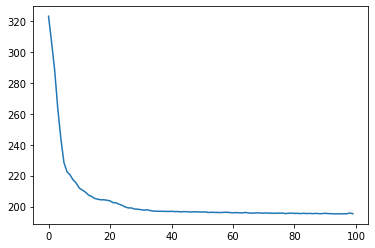

In [28]:
dtensor = torch.FloatTensor(df_test.to_numpy())
device = torch.device("cpu")
model = VAE(num_feats = 20,latent_dims=10).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

rmse,model_out = train_model(data_array=dtensor,model_in=model,
                optimizer_in=optimizer,device_in=device,epochs=100,batch_size=50,mask_in=nan_mask)

In [29]:
from torch.nn import BCELoss

In [30]:
def vae_imputation(model_in,df_true,df_missing,mask_df,feature_type):
    df_out = df_missing.copy()
    rmse_out = []
    loss_out = []
    mask_tensor = torch.FloatTensor(mask_df.to_numpy())
    loss = BCELoss()
    for i in range(1000): 
        model_in.eval()
        recon,_,_ = model_in.forward(torch.FloatTensor(df_out.to_numpy()))
        recon_df  = pd.DataFrame(data=recon.detach().numpy(),columns=mask_df.columns)
        df_out[mask_df==True] = recon_df
        
        for col in feature_type.columns:
            
            if feature_type[col].values == 'cat':
                
                df_out[col]   = df_out[col].round()
                recon_df[col] = recon_df[col].round()
                
        
        loss_out.append(loss((1-mask_tensor)*torch.FloatTensor(df_true.to_numpy()),
                (1-mask_tensor)*torch.FloatTensor(recon_df.to_numpy())).item())
        
        rmse_out.append(RMSE(mask_df.to_numpy()*df_true.to_numpy(),mask_df.to_numpy()*recon_df.to_numpy()))
    return df_out,rmse_out,loss_out

In [31]:
out,rmse,loss_out =vae_imputation(model_in=model_out,
               df_true=df_test,df_missing=df_test_nans_filled,
                         mask_df=nan_mask_df,feature_type=col_type)

In [32]:
model_out

VAE(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (fc11): Linear(in_features=20, out_features=10, bias=True)
  (fc12): Linear(in_features=10, out_features=5, bias=True)
  (fc21): Linear(in_features=5, out_features=10, bias=True)
  (fc22): Linear(in_features=5, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
  (fc31): Linear(in_features=5, out_features=10, bias=True)
  (fc32): Linear(in_features=10, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
)

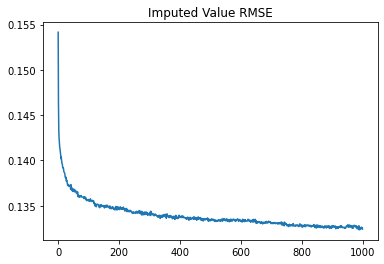

In [41]:
plt.plot(rmse)
plt.title('Imputed Value RMSE')
plt.show()

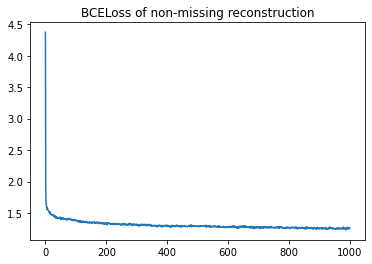

In [42]:
plt.plot(loss_out)
plt.title('BCELoss of non-missing reconstruction')
plt.show()

In [131]:
from sklearn.impute import KNNImputer

In [132]:
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(df_test_with_nans.to_numpy())
knn_imputed = imputer.transform(df_test_with_nans.to_numpy())

In [72]:
RMSE(df_test.to_numpy(),knn_imputed)

0.06681354269047694

In [133]:
RMSE(df_test.to_numpy(),out.to_numpy())

0.12327070894755376

In [134]:
from sklearn.metrics import mean_absolute_error

In [138]:
mean_absolute_error(df_test.to_numpy(),knn_imputed)

0.010079875387575191

In [139]:
mean_absolute_error(df_test.to_numpy(),out.to_numpy())

0.021095549656087665

OUTLIER DETECTION

In [45]:
import seaborn as sns

In [90]:
for col in df_test.columns:
    
    if col_type[col].item() == 'num':
        
        col_sigma = np.std(df_test[col])
        print(np.random.normal(0, 5*col_sigma))
    
    #df_test[col].plot.hist(bins=50)
    #plt.show()

-0.45885271010633216
0.2505002279502625
0.06017651920973859
0.4354019108935024
-0.14438312681638688
0.05228669256574634
-0.24570313338507252
-0.13892068638048816
0.6238141683749482
-0.4248255378266183
-1.3657338861697794


In [97]:
len(wine_df['quality'].unique())


7

In [151]:
probs_list = wine_df['quality'].astype('category').value_counts()/wine_df['quality'].astype('category').value_counts().sum()
tempered_probs_list = probs_list**0.5/np.sum(probs_list**0.5)
print(tempered_probs_list)
print(probs_list)

6    0.315779
5    0.274179
7    0.194779
4    0.087148
8    0.082378
3    0.032478
9    0.013259
Name: quality, dtype: float64
6    0.436509
5    0.329075
7    0.166077
4    0.033246
8    0.029706
3    0.004618
9    0.000770
Name: quality, dtype: float64


In [144]:
cats = list(probs_list.index.values)
np.random.choice(cats,p=probs)

6

In [152]:
wine_df


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,2
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,2
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,2
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,1


In [156]:
col_type = pd.DataFrame(data=np.array([np.nan]*13).reshape(1,13),columns=wine_df.columns)
for col in wine_df.columns:
    #print(col,len(df_scaled[col].unique()))
    
    if len(wine_df[col].unique()) < 10:
        col_type[col] = 'cat'
    else:
        col_type[col] = 'num'
col_type.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,num,num,num,num,num,num,num,num,num,num,num,cat,cat


In [165]:
for col in wine_df.columns:
    
    if col_type[col].item() == 'num':
        
        col_sigma = np.std(df_test[col])
        print(np.random.normal(0, 5*col_sigma))
        
    if col_type[col].item() == 'cat': 
        probs_list = wine_df[col].astype('category').value_counts()/wine_df[col].astype('category').value_counts().sum()
        tempered_probs_list = probs_list**0.5/np.sum(probs_list**0.5)
        cats  = list(probs_list.index.values)
        probs = tempered_probs_list.values
        print(np.random.choice(cats,p=probs))
    

-0.8480190654167054
-0.23208095903445633
-0.5913336504286023
-0.5619093817219833
-0.1526078040541117
0.022399712331134823
-0.9669440515895755
-0.052397970253784544
0.845350849519833
-0.12317059542064222
-0.773630294503787
7
1


In [225]:
#Corrupt Rows
def corrupt_rows(input_df,coltype_df,percent,num_sigma,alpha): 
    per_corrupt = percent
    num = int(input_df.shape[0]*per_corrupt)
    crs = np.random.randint(0,input_df.shape[0],size=num)
    
    df_out = input_df.copy()
    
    for row in crs:
    
        for ind,col in enumerate(input_df.columns):
            
            if coltype_df[col].item() == 'num':

                col_sigma = np.std(input_df[col])
                df_out.iloc[row,ind] += np.random.normal(0, num_sigma*col_sigma)

            if coltype_df[col].item() == 'cat': 
                probs_list = input_df[col].astype('category').value_counts()/input_df[col].astype('category').value_counts().sum()
                tempered_probs_list = probs_list**alpha/np.sum(probs_list**alpha)
                cats  = list(probs_list.index.values)
                probs = tempered_probs_list.values
                df_out.iloc[row,ind] = np.random.choice(cats,p=probs)
                
    
#         print('Input')  
#         print()
#         print(input_df.iloc[row,:])
#         print()
#         print()
#         print('Corrupted')
#         print()
#         print(df_out.iloc[row,:])
#         print('~~~~~~~~~~~~~~~~~~~')
#         print()
#         print()
    return df_out,crs

In [226]:
corrupt_dataframe,row_inds = corrupt_rows(input_df=wine_df,coltype_df=col_type,percent=0.1,num_sigma=2,alpha=1)

In [228]:
df = corrupt_dataframe.copy()

In [231]:
df = pd.concat([df,pd.get_dummies(df.quality,prefix='quality'),pd.get_dummies(df.wine_type,prefix='wine_type')],axis=1)

In [232]:
df.head(5)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,wine_type,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,...,2,0,0,0,1,0,0,0,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,...,2,0,0,0,1,0,0,0,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,...,2,0,0,0,1,0,0,0,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,...,2,0,0,0,1,0,0,0,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,...,2,0,0,0,1,0,0,0,0,1


In [233]:
scaler = MinMaxScaler()
scaler.fit(df.to_numpy())
df_scaled = pd.DataFrame(data=scaler.transform(df.to_numpy()),columns=df.columns)

In [234]:
df_scaled

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,...,wine_type,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,wine_type_1,wine_type_2
0,0.549577,0.444882,0.383267,0.524348,0.278686,0.428964,0.521540,0.428316,0.456456,0.362259,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.520884,0.457365,0.373779,0.322908,0.283783,0.356414,0.471470,0.323006,0.573578,0.378717,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.594666,0.449043,0.402243,0.378805,0.285058,0.393859,0.425353,0.339555,0.557962,0.358144,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.557775,0.428238,0.364290,0.395679,0.295253,0.433645,0.542623,0.347077,0.530633,0.341686,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.557775,0.428238,0.364290,0.395679,0.295253,0.433645,0.542623,0.347077,0.530633,0.341686,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0.516785,0.582193,0.250432,0.327127,0.336034,0.398540,0.355517,0.336546,0.632139,0.415747,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6493,0.504488,0.561389,0.259920,0.329236,0.300351,0.414922,0.364741,0.339856,0.659468,0.489807,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6494,0.520884,0.544745,0.274152,0.330291,0.318192,0.391519,0.350247,0.349183,0.620427,0.485693,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6495,0.504488,0.600918,0.269408,0.327127,0.316918,0.398540,0.355517,0.345121,0.678989,0.469235,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [240]:
df_scaled.to_numpy().sum(axis=1)

array([8.16199718, 7.88774925, 8.04665505, ..., 7.10148421, 6.96758195,
       7.09389689])